In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [4]:
df['date'].unique()

array(['2010-01-01', '2010-01-02', '2010-01-03', ..., '2016-12-29',
       '2016-12-30', '2016-12-31'], dtype=object)

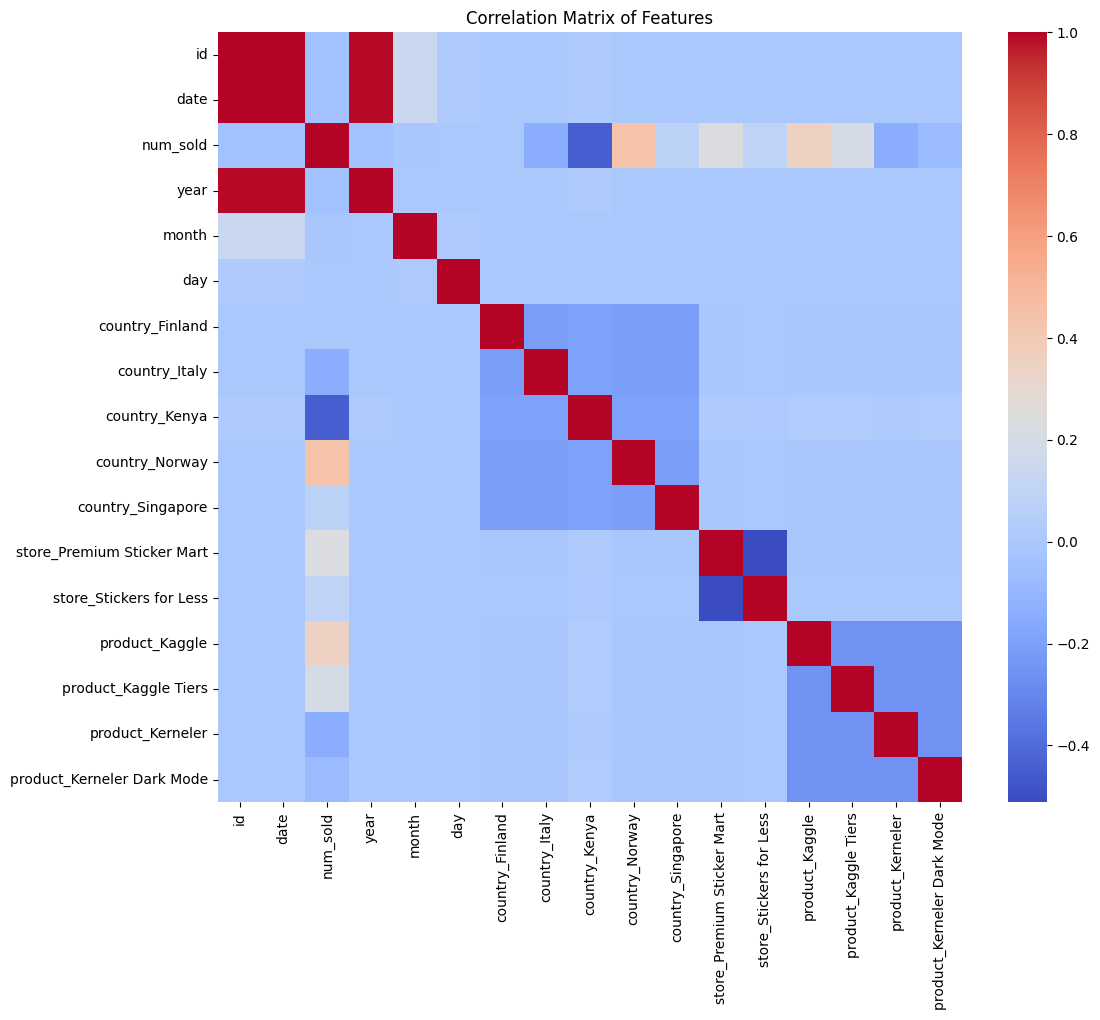

Correlation with num_sold:
num_sold                      1.000000
country_Norway                0.444573
product_Kaggle                0.356331
store_Premium Sticker Mart    0.231209
product_Kaggle Tiers          0.197389
store_Stickers for Less       0.089933
country_Singapore             0.073334
day                           0.001137
country_Finland              -0.002843
month                        -0.006255
year                         -0.040462
id                           -0.040866
date                         -0.040936
product_Kerneler Dark Mode   -0.075360
country_Italy                -0.139527
product_Kerneler             -0.145131
country_Kenya                -0.449873
Name: num_sold, dtype: float64


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
# df = pd.read_csv('your_dataset.csv')

# Drop rows with missing num_sold
df = df.dropna(subset=['num_sold'])

# Convert 'date' to datetime and extract features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['country', 'store', 'product'], drop_first=True)

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

# Correlation of features with num_sold
correlation_with_target = correlation_matrix['num_sold'].sort_values(ascending=False)
print("Correlation with num_sold:")
print(correlation_with_target)
